# Imports & Configuration

In [34]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
%matplotlib inline

# Generate the data

(100, 2)


<ipython-input-31-26da5f0a1bfb>:7: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.scatterplot(


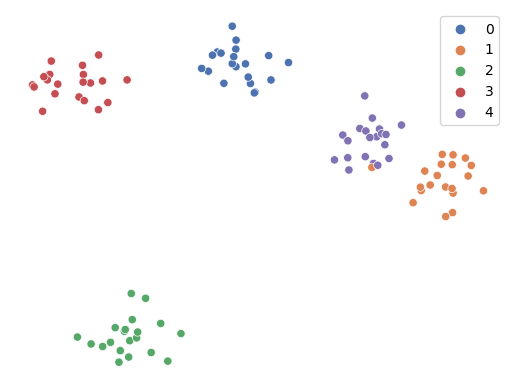

In [31]:
n_centers = 5
x_train, true_labels = make_blobs(n_samples=100, centers=n_centers, random_state=42)


print(x_train.shape)

ax = sns.scatterplot(
    x=x_train[:, 0], 
    y=x_train[:, 1], 
    hue=true_labels, 
    palette=sns.color_palette("deep", as_cmap=True))
ax.axis("off");

In [18]:
x_train[:, 0].shape, x_train[:, 1].shape

((100,), (100,))

# Переходим к реализации алгоритма

Нам будет необходимо рассчитывать расстояния между точками множество раз, поэтому напишем функцию, которая будет это делать

In [176]:
class CalcDist:
    def __init__(self) -> None:
        pass

    def __call__(self, point_coord: np.ndarray, data: np.ndarray, 
                 use_dim: str = "euclidean") -> np.ndarray:
        if use_dim == "euclidean":
            return self.euclidean(point_coord, data)
        if use_dim == "manhattan":
            return self.manhattan(point_coord, data)

    def euclidean(self, point_coord: np.ndarray, data: np.ndarray) -> np.ndarray:
        """
        Функция рассчета Евклидова расстояния (длина прямой, соединяющей две точки)
        """
        return np.sqrt(np.power(point_coord - data, 2).sum(axis=1, keepdims=False))
    
    def manhattan(self, point_coord: np.ndarray, data: np.ndarray) -> np.ndarray:
        """
        Функция рассчета Манхэттэнского расстояния
        """
        return np.sum(np.abs(point_coord - data), axis=1, keepdims=False)


In [177]:
calc = CalcDist()
p = np.array([0, 2])
q = np.array([
    [0, 3],
    [1, 3],
    [3, 7],
    ])
assert np.isclose(calc(p, q, use_dim="euclidean"), np.array([1, 1.41421356, 5.83095189])).all()
assert np.isclose(calc(p, q, use_dim="manhattan"), np.array([1, 2, 8])).all()

Переходим к написанию класса Kmeans

In [375]:
class KMeans:
    def __init__(self, n_centers: int = 8, max_iter: int = 300, 
                 use_dim: str = "euclidean", plus: bool = True) -> None:
        self.n_centers = n_centers
        self.max_iter = max_iter
        self.use_dim = use_dim
        self.plus = plus

    def fit(self, data: np.ndarray) -> None:
        # инициализируем случайным образом центройды
        self.centroids_initialization_(data=data)

        n_iter = 0
        prev_centroids = None

        # выполняем алгоритм до тех пор, пока центройды не перестали меняться
        # или не превышено количество итераций
        while np.not_equal(self.centroids, prev_centroids).any() and n_iter < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_centers)]

            for x in data:
                dists = CalcDist()(x, self.centroids, use_dim=self.use_dim)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)

            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]

            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            
            n_iter += 1

        return 

    def centroids_initialization_(self, data: np.ndarray) -> None:
        if self.plus:
            # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
            # then the rest are initialized w/ probabilities proportional to their distances to the first
            # Pick a random point from train data for first centroid
            self.centroids = [random.choice(data)]

            for _ in range(self.n_centers - 1):
                # Calculate distances from points to the centroids
                dist = np.sum([CalcDist()(centroid, data, use_dim=self.use_dim) for centroid in self.centroids], axis=0)

                # Normalize the distances
                dist /= np.sum(dist)

                # Choose remaining points based on their distances
                new_centroid_idx, = np.random.choice(range(len(data)), size=1, p=dist)
                self.centroids += [data[new_centroid_idx]]
            
            return

        # This initial method of randomly selecting centroid starts is less effective
        min_, max_ = data.min(axis=0), data.max(axis=0)
        self.centroids = [np.random.uniform(min_, max_) for _ in range(self.n_centers)]
        return
    
    def evaluate(self, data: np.ndarray):
        centroid_idxs = []

        for x in data:
            dists = CalcDist()(x, self.centroids, use_dim=self.use_dim)
            centroid_idx = np.argmin(dists)
            centroid_idxs.append(centroid_idx)
        return centroid_idxs


In [376]:
kmeans = KMeans(n_centers=5, plus=True, max_iter=300)
kmeans.fit(x_train)
classification = kmeans.evaluate(x_train)

<ipython-input-377-60d2d72f5b6d>:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.scatterplot(
<ipython-input-377-60d2d72f5b6d>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=np.array(kmeans.centroids)[:, 0], y=np.array(kmeans.centroids)[:, 1],


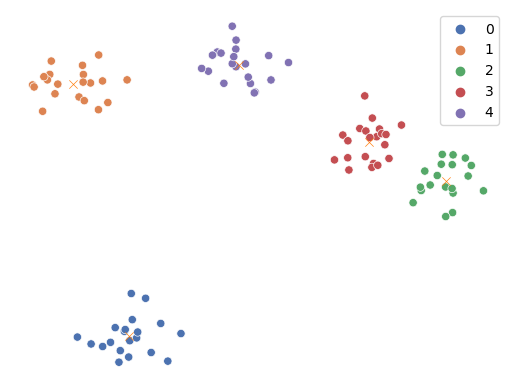

In [377]:
ax = sns.scatterplot(
    x=x_train[:, 0], 
    y=x_train[:, 1], 
    hue=classification, 
    palette=sns.color_palette("deep", as_cmap=True))
sns.scatterplot(x=np.array(kmeans.centroids)[:, 0], y=np.array(kmeans.centroids)[:, 1], 
                palette=sns.color_palette("deep", as_cmap=True), marker="x")
ax.axis("off");